<a href="https://colab.research.google.com/github/AlinaOkolzina/AlinaOkolzina/blob/master/Gener_Real_text_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

from lightgbm import LGBMClassifier

from tqdm import tqdm, tqdm_notebook
tqdm_notebook().pandas()

import warnings
warnings.filterwarnings('ignore')

nltk.download('punkt')
nltk.download('stopwords')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
df=pd.read_csv('train_40k.csv')

In [ ]:
def total_info(data):
    display(data.head())
    print(data.info())
    print("Количество пропусков", data.isna().mean().sort_values(ascending=True))
    print(data.describe())
    print("Количество дубликатов", data.duplicated().sum())

In [ ]:
total_info(df)

,Unnamed: 0,id,ended,length,sentence,label
0,20280,20280,True,925,Out goes David Brent's long-lost footballing t...,natural
1,157379,157379,True,539,"From 24/7 Wall St.: Between 2010 and 2020, the...",natural
2,64538,65763,False,1024,"TAMPA, Fla. – He was being held on $250,000 ba...",generated
3,162539,165669,False,1024,02kb:*.2.0\n\nMozilla Firefox Version 12\n\n\n...,generated
4,173465,173465,True,342,As many as 50 witnesses will give evidence dur...,natural


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  40000 non-null  int64 
 1   id          40000 non-null  int64 
 2   ended       40000 non-null  bool  
 3   length      40000 non-null  int64 
 4   sentence    40000 non-null  object
 5   label       40000 non-null  object
dtypes: bool(1), int64(3), object(2)
memory usage: 1.6+ MB
None
Количество пропусков Unnamed: 0    0.0
id            0.0
ended         0.0
length        0.0
sentence      0.0
label         0.0
dtype: float64
          Unnamed: 0             id        length
count   40000.000000   40000.000000  40000.000000
mean   124145.713925  125329.144375    639.278725
std     71720.698553   72403.410702    366.896644
min         6.000000       7.000000     20.000000
25%     61964.750000   62453.500000    279.000000
50%    124415.500000  125600.000000    677.000000
75%    186254.

In [ ]:
df.loc[(df.label == "generated"), 'label'] = 1
df.loc[(df.label == "natural"), 'label'] = 0
df = df.astype ({'label':np.int64})

In [ ]:
total_info(df)

,Unnamed: 0,id,ended,length,sentence,label
0,20280,20280,True,925,Out goes David Brent's long-lost footballing t...,0
1,157379,157379,True,539,"From 24/7 Wall St.: Between 2010 and 2020, the...",0
2,64538,65763,False,1024,"TAMPA, Fla. – He was being held on $250,000 ba...",1
3,162539,165669,False,1024,02kb:*.2.0\n\nMozilla Firefox Version 12\n\n\n...,1
4,173465,173465,True,342,As many as 50 witnesses will give evidence dur...,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  40000 non-null  int64 
 1   id          40000 non-null  int64 
 2   ended       40000 non-null  bool  
 3   length      40000 non-null  int64 
 4   sentence    40000 non-null  object
 5   label       40000 non-null  int64 
dtypes: bool(1), int64(4), object(1)
memory usage: 1.6+ MB
None
Количество пропусков Unnamed: 0    0.0
id            0.0
ended         0.0
length        0.0
sentence      0.0
label         0.0
dtype: float64
          Unnamed: 0             id        length         label
count   40000.000000   40000.000000  40000.000000  40000.000000
mean   124145.713925  125329.144375    639.278725      0.500000
std     71720.698553   72403.410702    366.896644      0.500006
min         6.000000       7.000000     20.000000      0.000000
25%     61964.750000   62453.500000    279.0

Text(0.5, 1.0, 'Распределение целевого признака')

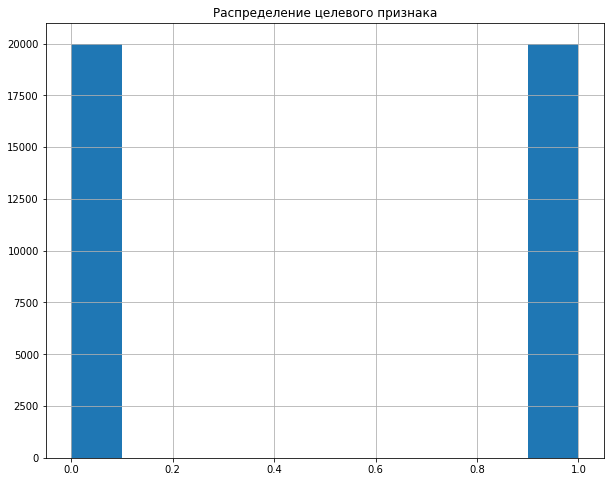

In [ ]:
plt.figure(figsize=(10, 8))
df['label'].hist()
plt.title('Распределение целевого признака')

In [ ]:
df2=pd.read_csv('test_5k.csv')

In [ ]:
total_info(df2)

,Unnamed: 0,id,ended,length,sentence,label
0,4722,259722,True,231,The Learning Co.\n\nDeveloped by\n\nThe Learni...,natural
1,2757,257813,True,563,Bush doubles down on foreign policy on Saturda...,generated
2,2194,257194,True,62,Here are six interesting things you need to kn...,natural
3,817,255817,True,293,Introduction\n\nWe would like to thank Antec f...,natural
4,3886,258886,False,1024,"ELKRIDGE, Md.—A group called ""Muslims for Trum...",natural


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5000 non-null   int64 
 1   id          5000 non-null   int64 
 2   ended       5000 non-null   bool  
 3   length      5000 non-null   int64 
 4   sentence    5000 non-null   object
 5   label       5000 non-null   object
dtypes: bool(1), int64(3), object(2)
memory usage: 200.3+ KB
None
Количество пропусков Unnamed: 0    0.0
id            0.0
ended         0.0
length        0.0
sentence      0.0
label         0.0
dtype: float64
        Unnamed: 0             id       length
count  5000.000000    5000.000000  5000.000000
mean   2462.215200  257487.854200   641.122400
std    1425.820965    1439.683534   364.391166
min       0.000000  255001.000000    20.000000
25%    1228.750000  256243.750000   293.000000
50%    2439.500000  257464.500000   674.000000
75%    3688.250000  258733.000000  

In [ ]:
df2.loc[(df2.label == "generated"), 'label'] = 1
df2.loc[(df2.label == "natural"), 'label'] = 0
df2 = df2.astype ({'label':np.int64})

In [ ]:
total_info(df2)

,Unnamed: 0,id,ended,length,sentence,label
0,4722,259722,True,231,The Learning Co.\n\nDeveloped by\n\nThe Learni...,0
1,2757,257813,True,563,Bush doubles down on foreign policy on Saturda...,1
2,2194,257194,True,62,Here are six interesting things you need to kn...,0
3,817,255817,True,293,Introduction\n\nWe would like to thank Antec f...,0
4,3886,258886,False,1024,"ELKRIDGE, Md.—A group called ""Muslims for Trum...",0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5000 non-null   int64 
 1   id          5000 non-null   int64 
 2   ended       5000 non-null   bool  
 3   length      5000 non-null   int64 
 4   sentence    5000 non-null   object
 5   label       5000 non-null   int64 
dtypes: bool(1), int64(4), object(1)
memory usage: 200.3+ KB
None
Количество пропусков Unnamed: 0    0.0
id            0.0
ended         0.0
length        0.0
sentence      0.0
label         0.0
dtype: float64
        Unnamed: 0             id       length       label
count  5000.000000    5000.000000  5000.000000  5000.00000
mean   2462.215200  257487.854200   641.122400     0.50000
std    1425.820965    1439.683534   364.391166     0.50005
min       0.000000  255001.000000    20.000000     0.00000
25%    1228.750000  256243.750000   293.000000     0.00000
50%    243

In [ ]:
def target_features_split(df, target_col):
    target = df[target_col]
    features = df.drop([target_col], axis=1)
    return target, features

In [ ]:
target_train, features_train = target_features_split(df, 'label')
target_test, features_test = target_features_split(df2, 'label')

'Сравнение ключевого признака в тренировочной и тестовой выборках'

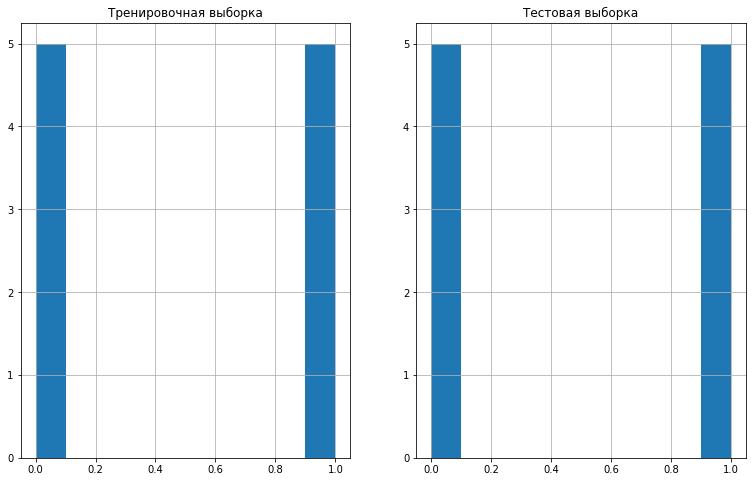

In [ ]:
plt.figure(figsize=(13, 8))
plt.subplot(121)
plt.title('Тренировочная выборка')
target_train.hist(density=True)

plt.subplot(122)
plt.title('Тестовая выборка')
target_test.hist(density=True)
display('Сравнение ключевого признака в тренировочной и тестовой выборках')

In [ ]:
df = df.drop('id', axis=1)


In [ ]:
df = df.drop('ended', axis=1)
df = df.drop('length', axis=1)

In [ ]:
total_info(df)

,Unnamed: 0,sentence,label
0,20280,Out goes David Brent's long-lost footballing t...,0
1,157379,"From 24/7 Wall St.: Between 2010 and 2020, the...",0
2,64538,"TAMPA, Fla. – He was being held on $250,000 ba...",1
3,162539,02kb:*.2.0\n\nMozilla Firefox Version 12\n\n\n...,1
4,173465,As many as 50 witnesses will give evidence dur...,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  40000 non-null  int64 
 1   sentence    40000 non-null  object
 2   label       40000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 937.6+ KB
None
Количество пропусков Unnamed: 0    0.0
sentence      0.0
label         0.0
dtype: float64
          Unnamed: 0         label
count   40000.000000  40000.000000
mean   124145.713925      0.500000
std     71720.698553      0.500006
min         6.000000      0.000000
25%     61964.750000      0.000000
50%    124415.500000      0.500000
75%    186254.250000      1.000000
max    249997.000000      1.000000
Количество дубликатов 0


In [ ]:
df2 = df2.drop('id', axis=1)
df2 = df2.drop('ended', axis=1)
df2 = df2.drop('length', axis=1)

In [ ]:
total_info(df2)

,Unnamed: 0,sentence,label
0,4722,The Learning Co.\n\nDeveloped by\n\nThe Learni...,0
1,2757,Bush doubles down on foreign policy on Saturda...,1
2,2194,Here are six interesting things you need to kn...,0
3,817,Introduction\n\nWe would like to thank Antec f...,0
4,3886,"ELKRIDGE, Md.—A group called ""Muslims for Trum...",0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5000 non-null   int64 
 1   sentence    5000 non-null   object
 2   label       5000 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 117.3+ KB
None
Количество пропусков Unnamed: 0    0.0
sentence      0.0
label         0.0
dtype: float64
        Unnamed: 0       label
count  5000.000000  5000.00000
mean   2462.215200     0.50000
std    1425.820965     0.50005
min       0.000000     0.00000
25%    1228.750000     0.00000
50%    2439.500000     0.50000
75%    3688.250000     1.00000
max    4997.000000     1.00000
Количество дубликатов 0


In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
lemmatizer = WordNetLemmatizer()
def lemmatization(text):
    word_list = nltk.word_tokenize(text)
    return ' '.join([lemmatizer.lemmatize(w) for w in word_list])

In [ ]:
features_train['sentence'] = features_train['sentence'].progress_apply(lemmatization)


  0%|          | 0/40000 [00:00<?, ?it/s]

In [ ]:
def clear_text(text):
    return ' '.join(re.sub(r'[^a-z]', ' ',text.lower()) .split())

In [ ]:
features_train['sentence'] = features_train['sentence'].progress_apply(clear_text)

  0%|          | 0/40000 [00:00<?, ?it/s]

In [ ]:
stop_words = set(nltk_stopwords.words('english'))
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,2))
features_train = tfidf_vectorizer.fit_transform(features_train['sentence'].astype('U'))

In [ ]:
def preprocessing(df):
    df = df.apply(lemmatization)# лемматизация
    df = df.apply(clear_text)# чистка
    df = tfidf_vectorizer.transform(df.astype('U'))# векторизация
    return df
features_test = preprocessing(features_test['sentence'])

In [ ]:
results = pd.DataFrame(columns=['model', 'f1_score'])


In [ ]:
%time
model_LR = LogisticRegression()
#model_LR = LogisticRegression(random_state=42, class_weight='balanced')
#parameters = [{'C': [8.7, 8.8, 8.6]}]

#LR_model_gscv = GridSearchCV(model_LR, param_grid=parameters, scoring='f1', n_jobs=-1,  cv=5, verbose=True)
model_LR.fit(features_train, target_train)
#print(LR_model_gscv.best_params_)
#results.loc[len(results)] = ['LogisticRegression train', '{:.4f}'.format(model_LR.best_score_)]
#results.loc[len(results)] = ['LogisticRegression train', '{:.4f}'.format(model_LR.best_score_)]
#results

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 19.6 µs


LogisticRegression()

In [ ]:
%time
predict = model_LR.predict(features_test)
print('F1: {:.4f}'.format(f1_score(target_test, predict)))

#results.loc[len(results)] = ['LogisticRegression test', '{:.4f}'.format(f1_score(target_test, predict))]

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs
F1: 0.7594


In [ ]:
survival = model_LR.predict(features_test)
print ("Generated", sum(survival!=0))
print ("No generated", sum(survival==0))

Generated 2807
No generated 2193


array([[1708,  792],
       [ 485, 2015]])

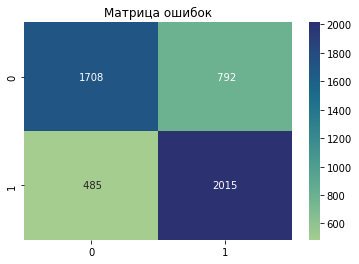

In [ ]:
from sklearn.metrics._plot.confusion_matrix import confusion_matrix
import seaborn as sb
conf_mx = confusion_matrix(target_test,survival)
sb.heatmap(conf_mx, annot=True, fmt='4.0f', cmap='crest')
plt.title('Матрица ошибок', size = 12)
conf_mx

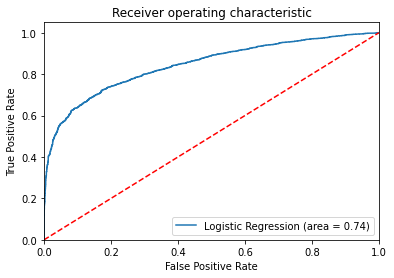

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(target_test, model_LR.predict(features_test))
fpr, tpr, thresholds = roc_curve(target_test, model_LR.predict_proba(features_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Для идеального классификатора график ROC-кривой проходит через верхний левый угол, где доля истинно положительных случаев составляет 100% или 1,0 (идеальная чувствительность), а доля ложно положительных примеров равна нулю. Поэтому чем ближе кривая к верхнему левому углу, тем выше предсказательная способность модели. Наоборот, чем меньше изгиб кривой и чем ближе она расположена к диагональной прямой, тем менее эффективна модель. Диагональная линия соответствует «бесполезному» классификатору, т.е. полной неразличимости двух классов.



In [ ]:
model_LR.predict_proba(features_test)

array([[0.69212329, 0.30787671],
       [0.52380109, 0.47619891],
       [0.67068449, 0.32931551],
       ...,
       [0.39286035, 0.60713965],
       [0.58883076, 0.41116924],
       [0.18020994, 0.81979006]])

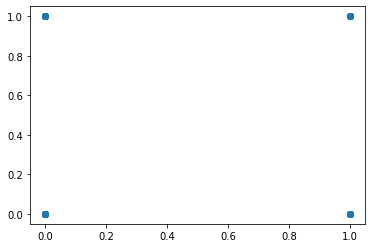

In [ ]:
plt.scatter(target_test, predict)
